This is the model structure:

Model = F(Portfolio Distribution, Component Features) -> Better Portfolio Distribution

Portfolio Distribution is expressed in form of a discrete probability distribution

Each component feature(feature of a stock) is expressed in form of a list whose elements are one dimensional vectors, so each component feature is 2 dimensional vector. For simplicity, our project only uses simple linear regression as the wave's feature.

We decompose our model into three parts:
- To extract the feature of each stock component, F_component(Feature) -> A "component feature size" dimensional vector, F_component is a simple Deep Neural Network, with feature vector flattened for simplicity of our project
- To extract the feature of the entire market, F_market(Component Features) -> A "market feature size" dimensional vector, F_market is a permulation invariant deep neural network, implemented by using handcrafted permulation invariant function on a set, such as Sum, Max, Min, and using a Deep Neural Network to further extract those feature. 
- To regress the optimality of portfolio based on reward and risk, F(Portfolio Distribution, Component Features) = "F_optimize(F_component(Component Features[i]), F_market(Component Features), Portfolio Distribution[i])" for i from 1 to portfolio length. F_optimize is a simple Deep Neural Network

A data slice contains 10000 samples, each sample has structure as follow:
- Reward of P1:
  - Profit score of P1, higher is better
  - Risk score of P1, lower is better
- Reward of P2:
  - Profit score of P2, higher is better
  - Risk score of P2, lower is better
- P1
- P2
- Component Features:
  - Each component's features

In [ ]:
COMPONENT_FEATURE_SIZE = 128
MARKET_FEATURE_SIZE = 128

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

# Import libraries, dependencies, and some other things

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax
import pickle
import functools
import itertools
import operator
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def functools_reduce(a):
    return functools.reduce(operator.concat, a)

In [ ]:
def flatten(lst):
  if isinstance(lst, list):
    return functools_reduce([flatten(iter) for iter in lst])
  else:
    return [lst]

In [ ]:
PRNGkey = jax.random.PRNGKey(98200289)

# Load a data slice, drive & path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# %cd "/content/drive/MyDrive/Model for Automated Portfolio Optimization"

path = "/content/drive/MyDrive/Model for Automated Portfolio Optimization"
model_file_path = path + "/model"
data = path + "/data/amibroker_all_data.txt"
data_path = path
dataset_path = path + "/Wave Dataset"

Mounted at /content/drive


In [ ]:
sample_data_slice = None
with open(dataset_path + "/" + "dataset1.pickle", "rb") as input_file:
  sample_data_slice = pickle.load(input_file)

# Multi-layer-perceptron related functions

In [ ]:
def init_mlp_params(layer_widths):
  global PRNGkey
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=jax.random.normal(key=PRNGkey, shape=(n_in, n_out), dtype=jnp.float64) * jnp.sqrt(2/n_in),
             biases=jnp.zeros(shape=(n_out,), dtype=jnp.float64)
            )
    )
    PRNGkey, subkey = jax.random.split(PRNGkey)
  return params

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.selu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

# Unrelated

In [ ]:
# print(sample_data_slice[0])
print(sample_data_slice[0][0], sample_data_slice[0][1], sample_data_slice[0][2], sample_data_slice[0][3], sample_data_slice[0][4], sep='\n')
print(sample_data_slice[0][4][0])

(1580722.8276371295, 153626.5615901734)
(1581512.574951846, 154418.22576701664)
[0.10731467 0.00111015 0.05896139 0.01159492 0.         0.01603552
 0.04785987 0.         0.05513754 0.         0.         0.10373751
 0.         0.09004564 0.         0.00357716 0.         0.
 0.         0.         0.08683853 0.         0.         0.04243247
 0.         0.10398421 0.0629086  0.         0.07438017 0.05008018
 0.08400148]
[0.11004709 0.00112167 0.06160976 0.01177857 0.         0.01595709
 0.05236351 0.         0.05348982 0.         0.         0.09801208
 0.         0.09301581 0.         0.00356443 0.         0.
 0.         0.         0.08671073 0.         0.         0.04250888
 0.         0.11274257 0.06115142 0.         0.07153718 0.04631699
 0.07807241]
[[[[0.003576602609921082, 0.0028970730855969445, 0.005779753700222181, 0.20807111818896346], 1], [[-8.52213517080876e-05, -0.0005132468574880396, -0.0008502658743746792, -0.023378291137360906], 1], [[-0.0020910549267016613, -0.0011203739450

In [ ]:
print(type(sample_data_slice))

<class 'list'>


In [ ]:
temp = flatten(sample_data_slice[0][4][0])
print(len(temp))
print(temp)

30
[0.003576602609921082, 0.0028970730855969445, 0.005779753700222181, 0.20807111818896346, 1, -8.52213517080876e-05, -0.0005132468574880396, -0.0008502658743746792, -0.023378291137360906, 1, -0.0020910549267016613, -0.0011203739450659736, -0.0017460543833088267, -0.03803428064054287, 1, 0.0005814734264321544, 0.0006354242321277855, 0.0007014479405142458, -0.006157002315861449, 1, -0.0014039151931375426, -0.001257271111539436, -0.0012908111825477792, -0.012613602444800073, 1, 0, 0, 0, 0, 1]


# Visualize data

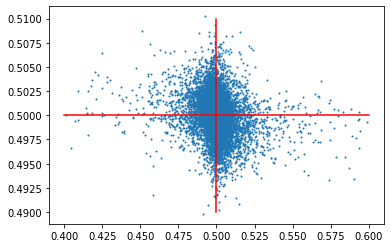

In [ ]:
temp_visualize_data_x = []
temp_visualize_data_y = []
cnt = 0
for i in sample_data_slice:
  if i[0][1]/(i[1][1] + i[0][1] + 0.001) < 0.4 or i[0][1]/(i[1][1] + i[0][1] + 0.001) > 0.6 :
    continue
  temp_visualize_data_x.append(i[0][0]/(i[0][0] + i[1][0] + 0.001))
  temp_visualize_data_y.append(i[0][1]/(i[1][1] + i[0][1] + 0.001))

plt.scatter(temp_visualize_data_y, temp_visualize_data_x, s=1)
x = np.linspace(0.4, 0.6, 100)
x_ = np.linspace(0.49, 0.51, 100)
def temp(x):
  return x - x + 0.5
plt.plot(x, temp(x), 'r')
plt.plot(temp(x_), x_, 'r')
plt.show()

In [ ]:
print(len(temp_visualize_data_y))

9157


# Defining models for component extraction

(List of numpy matrices)

In [ ]:
component_model_params = init_mlp_params([30, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE, 
                                          COMPONENT_FEATURE_SIZE])

# Defining models for market data extraction

Two model, component -> component feature ->(1) component feature(market) -> average ->(2) market feature

In [ ]:
market_model_1_params = init_mlp_params([COMPONENT_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE])

market_model_2_params = init_mlp_params([MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE, 
                                         MARKET_FEATURE_SIZE])

In [ ]:
@jit
def market_model_forward(market_model_1_params,
                         market_model_2_params,
                         components):
  @jit
  def forward_market_1(x):
    *hidden, last = market_model_1_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  @jit
  def forward_market_2(x):
    *hidden, last = market_model_2_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  
  vmap_market_model_1_forward_function = vmap(forward_market_1)
  vmap_market_model_2_forward_function = vmap(forward_market_2)
  cur = vmap_market_model_1_forward_function(components)
  cur = jnp.nan_to_num(cur)
  cur = jnp.average(cur, axis=1)
  cur = vmap_market_model_2_forward_function(cur)
  return cur

# Defining model for optimize function

In [ ]:
optimize_model_params = init_mlp_params([COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         1])

optimize_model_params_negative = init_mlp_params([COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1, 
                                         COMPONENT_FEATURE_SIZE + MARKET_FEATURE_SIZE + 1,
                                         1])

In [ ]:
@jit
def opt_forward(component_model_params, 
                market_model_1_params,
                market_model_2_params,
                optimize_model_params,
                optimize_model_params_negative,
                wave_data, dist):
  @jit
  def component_function(x):
    *hidden, last = component_model_params
    x = jnp.nan_to_num(x)
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
      x = jnp.nan_to_num(x)
    x = x @ last['weights'] + last['biases']
    x = jnp.nan_to_num(x)
    return x
  vmap_component_function = vmap(component_function)
  current = vmap(vmap_component_function)(wave_data)
  # print(current)
  current_market = jnp.copy(current)
  current_market = market_model_forward(market_model_1_params,
                                        market_model_2_params,
                                        current_market)
  current_market = jnp.expand_dims(current_market, axis=1)
  current_market = jnp.repeat(current_market, current.shape[1], axis=1)
  dist = jnp.expand_dims(dist, axis=2)
  current = jnp.concatenate([current, current_market, dist], axis=2)
  copy_of_current = jnp.copy(current)
  @jit
  def forward_opt(x):
    *hidden, last = optimize_model_params
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  current = vmap(forward_opt)(current)
  current = jnp.squeeze(current, axis=2)
  current = jax.nn.softmax(current)

  @jit
  def forward_opt_negative(x):
    *hidden, last = optimize_model_params_negative
    for layer in hidden:
      x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']
  copy_of_current = vmap(forward_opt_negative)(copy_of_current)
  copy_of_current = jnp.squeeze(copy_of_current, axis=2)
  copy_of_current = jax.nn.softmax(copy_of_current) * -1
  return current + copy_of_current

opt_fw = jax.jit(opt_forward)

# Training loop

In [ ]:
def softmax(x):
  x = jnp.asarray(x)
  return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=0)

def de_softmax(x):
  x = jnp.asarray(x)
  return jnp.log(x + 0.001) - jnp.average(jnp.log(x + 0.001), axis=0)

def prob(x):
  x = jnp.asarray(x)
  return x / jnp.sum(x, axis=0)

def add_noise(x):
  x = jnp.asarray(x)
  x = x + jnp.random.uniform(-0.1, 0.1, x.shape)
  return x

def generate_random_probability():
  portfolio_dummy = [jax.random.randint(1, 1000) for i in range(31)]
  return prob(portfolio_dummy)

def generate_noise_probability(x):
  return softmax(add_noise(de_softmax(x)))

In [ ]:
def compare(p1, p2):
  if p1[0] < p2[0] and p1[1] > p2[1]: # p1 is inferior to p2
    return (3, 3)
  if p1[0] > p2[0] and p1[1] < p2[1]: # p1 is better to p2
    return (2, 2)
  return (2, 3) # everyone has a better perk

In [ ]:
def mse(x):
  # res = jax.scipy.special.xlogy(x[1], x[1]) - jax.scipy.special.xlogy(x[1], x[0])
  res = ((x[1] - x[0])**2)
  # res = jnp.nan_to_num(res)
  # print(res)
  res = jnp.average(res)
  # print(res)
  # print(x)
  return res

# mse_jt = mse
mse_jt = jax.jit(mse)

@jit
def loss_fn(params,
            feature_tmp, portfolio_base_temp, portfolio_better_temp):
  component_model_params_, market_model_1_params_, market_model_2_params_, optimize_model_params_, optimize_model_params_negative = params
  res = opt_forward(component_model_params_, 
                    market_model_1_params_,
                    market_model_2_params_,
                    optimize_model_params_,
                    optimize_model_params_negative,
                    feature_tmp, portfolio_base_temp)
  lol=portfolio_better_temp - portfolio_base_temp
  # print(res)
  # print(lol)
  res = jnp.stack([res, portfolio_better_temp - portfolio_base_temp], axis=1)
  res = jnp.average(vmap(mse_jt)(res))
  return res

In [ ]:
print(jax.tree_map(lambda x: x.shape, component_model_params)) 
print(jax.tree_map(lambda x: x.shape, market_model_1_params))
print(jax.tree_map(lambda x: x.shape, market_model_2_params))
print(jax.tree_map(lambda x: x.shape, optimize_model_params))

[{'biases': (128,), 'weights': (30, 128)}, {'biases': (128,), 'weights': (128, 128)}, {'biases': (128,), 'weights': (128, 128)}]
[{'biases': (128,), 'weights': (128, 128)}, {'biases': (128,), 'weights': (128, 128)}]
[{'biases': (128,), 'weights': (128, 128)}, {'biases': (128,), 'weights': (128, 128)}, {'biases': (128,), 'weights': (128, 128)}, {'biases': (128,), 'weights': (128, 128)}]
[{'biases': (257,), 'weights': (257, 257)}, {'biases': (257,), 'weights': (257, 257)}, {'biases': (1,), 'weights': (257, 1)}]


In [ ]:
for L in range(0, 100):
  prof_risk = []; prof_risk_diff = []; soft = []; soft_diff = []; feature = []
  prof_risk_tmp = []; prof_risk_diff_tmp = []; soft_tmp = []; soft_diff_tmp = []; feature_tmp = []
  portfolio_base = []; portfolio_better = []
  portfolio_base_temp = []; portfolio_better_temp = []
  cnt = 0
  random.shuffle(sample_data_slice)
  for sample in sample_data_slice:
    # prof_risk_tmp.append(list(sample[0]))
    # prof_risk_diff_tmp.append(list(sample[1]))
    # soft_tmp.append(list(sample[2]))
    # soft_diff_tmp.append(list(sample[3]))
    # feature_tmp.append(flatten(sample[4]))
    portfolio_comparison_check = compare(sample[0], sample[1])
    feature_tmp.append([flatten(x) for x in sample[4]])
    feature_tmp[-1].append([0 for i in range(30)])
    feature_tmp.append([flatten(x) for x in sample[4]])
    feature_tmp[-1].append([0 for i in range(30)])
    # print(feature_tmp)
    # break
    portfolio_base_temp.append(sample[2])
    # print(sample[2])
    # break
    portfolio_base_temp.append(sample[3])
    portfolio_better_temp.append(sample[portfolio_comparison_check[0]])
    portfolio_better_temp.append(sample[portfolio_comparison_check[1]])
    cnt +=1
    if len(feature_tmp) == 512 or cnt == len(sample_data_slice):
      LEARNING_RATE = 0.01
      print("LR: ", LEARNING_RATE)
      feature_tmp = jnp.asarray(feature_tmp)
      portfolio_base_temp = jnp.asarray(portfolio_base_temp)
      portfolio_better_temp = jnp.asarray(portfolio_better_temp)
      d_loss = jax.grad(loss_fn)(
                                (component_model_params, 
                                market_model_1_params,
                                market_model_2_params,
                                optimize_model_params,
                                optimize_model_params_negative),
                                feature_tmp, portfolio_base_temp, portfolio_better_temp)
      print(loss_fn((component_model_params, 
                                market_model_1_params,
                                market_model_2_params,
                                optimize_model_params,
                                optimize_model_params_negative),
                                feature_tmp, portfolio_base_temp, portfolio_better_temp))
      params = component_model_params, market_model_1_params, market_model_2_params, optimize_model_params, optimize_model_params_negative
      component_model_params, market_model_1_params, market_model_2_params, optimize_model_params, optimize_model_params_negative = jax.tree_map(lambda p, g: p - LEARNING_RATE * g, params, d_loss)
      print(cnt/len(sample_data_slice))
      feature_tmp = []
      portfolio_base_temp = []
      portfolio_better_temp = []
      # break
  # print(portfolio_base_temp.shape)
  # print(portfolio_base_temp)

LR:  0.01
3.3144253367405376e-06
0.0256
LR:  0.01
3.254666642245219e-06
0.0512
LR:  0.01
3.25050969999328e-06
0.0768
LR:  0.01
3.0055269044706226e-06
0.1024
LR:  0.01
3.145610131834727e-06
0.128
LR:  0.01
2.918631121384878e-06
0.1536
LR:  0.01
3.266309267208975e-06
0.1792
LR:  0.01
2.5728596473027882e-06
0.2048
LR:  0.01
2.9387256671657084e-06
0.2304
LR:  0.01
2.8672967535694056e-06
0.256
LR:  0.01
2.7835923057343245e-06
0.2816
LR:  0.01
2.8677117590095864e-06
0.3072
LR:  0.01
2.699118521636712e-06
0.3328
LR:  0.01
2.7036011633531186e-06
0.3584
LR:  0.01
3.1498825574610534e-06
0.384
LR:  0.01
2.862092293205922e-06
0.4096
LR:  0.01
3.2118948638572725e-06
0.4352
LR:  0.01
2.8852610256592497e-06
0.4608
LR:  0.01
3.3027486714089e-06
0.4864
LR:  0.01
3.0462461554160664e-06
0.512
LR:  0.01
2.7140455050963864e-06
0.5376
LR:  0.01
3.0745788698535425e-06
0.5632
LR:  0.01
3.0407677924416767e-06
0.5888
LR:  0.01
3.076062966523235e-06
0.6144
LR:  0.01
2.884275073150944e-06
0.64
LR:  0.01
2.8068488

KeyboardInterrupt: ignored

In [ ]:
market_model_2_params

[{'biases': DeviceArray([ 0.00000000e+00, -6.66397588e-06, -4.79092193e-04,
               -1.57165031e-05,  3.60031982e-05,  0.00000000e+00,
               -9.39393440e-05, -1.89942704e-04,  0.00000000e+00,
                4.82139990e-04,  0.00000000e+00,  3.29164408e-04,
               -4.03103881e-04, -3.08325438e-04,  1.01555391e-04,
               -1.42120553e-05,  9.70272111e-07, -4.81183145e-05,
               -4.28149990e-04,  7.80461237e-05, -2.73126592e-04,
               -1.88305729e-04,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  7.40992247e-05,  2.65348728e-04,
                1.05046398e-04, -1.08270185e-06, -5.04001432e-04,
                0.00000000e+00, -3.38928241e-04,  4.14809845e-07,
                0.00000000e+00, -2.88475633e-04,  4.32606769e-04,
                2.67029894e-04,  0.00000000e+00,  5.59087926e-04,
               -2.62059909e-06, -3.90683171e-04,  2.35787299e-04,
                0.00000000e+00,  0.00000000e+00,  0.00000000e+00,


In [ ]:
market_model_2_params

[{'biases': DeviceArray([-4.81224335e-06, -4.13234027e-07,  2.76900844e-10,
               -1.35929634e-07, -1.46536797e-09, -5.26635564e-09,
               -9.31013924e-08,  1.37722104e-09, -2.00445178e-08,
               -5.90140261e-06,  8.39745057e-11,  3.31106841e-07,
                1.00765828e-05,  6.86975815e-06,  0.00000000e+00,
               -8.20785108e-06,  4.44708503e-09,  3.61340204e-06,
                0.00000000e+00,  0.00000000e+00,  6.38075351e-09,
               -1.02707054e-10, -2.29867919e-08,  0.00000000e+00,
                7.96667632e-06,  4.49476669e-06,  4.31752830e-06,
                0.00000000e+00,  1.54825315e-05,  1.00718794e-05,
                0.00000000e+00,  6.89214742e-06,  4.07096239e-06,
               -7.40948332e-06,  0.00000000e+00, -2.64497569e-10,
                3.74075551e-10,  2.83194065e-06,  2.18904438e-06,
                0.00000000e+00,  0.00000000e+00, -1.90736816e-10,
               -3.34397751e-06,  8.84455770e-07,  0.00000000e+00,


In [ ]:
jnp.save(model_file_path + '/comp_t.npy', component_model_params)
jnp.save(model_file_path + '/mar1_t.npy', market_model_1_params)
jnp.save(model_file_path + '/mar2_t.npy', market_model_2_params)
jnp.save(model_file_path + '/opt_t.npy', optimize_model_params)
jnp.save(model_file_path + '/opt_neg_t.npy', optimize_model_params_negative)

In [ ]:
print(sample_data_slice[0])

In [ ]:
random.shuffle(sample_data_slice)

In [ ]:
print(len(d_loss))
print(d_loss[2])

5
[{'biases': DeviceArray([ 0.00000000e+00,  5.04849271e-08,  1.76826576e-08,
             -8.17820437e-08, -2.85657023e-08,  0.00000000e+00,
              5.11713786e-08,  9.78320532e-08,  0.00000000e+00,
              4.71009927e-08,  0.00000000e+00,  7.90089754e-08,
             -2.81598399e-08,  1.98533823e-07,  9.34760758e-08,
              5.27628368e-09,  0.00000000e+00,  7.50090172e-08,
              2.31468744e-07, -1.66576575e-07,  4.35559301e-08,
             -3.92008495e-08,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00, -4.94013983e-08, -5.49413909e-08,
             -5.03945933e-08, -3.61033035e-09,  1.55975383e-08,
              0.00000000e+00,  3.57389181e-08,  0.00000000e+00,
              0.00000000e+00,  1.59579025e-07, -1.10660893e-07,
              9.28168620e-08,  0.00000000e+00, -3.12204821e-08,
              0.00000000e+00,  1.20022404e-07,  7.06947493e-08,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             -1.32793153e-

# Evaluate